## RQ1. 각 approach의 proposed changes는 defect가 예측된 코드에 대한 decision을 얼마나 flip하는가?
### Motivation
developers in practice는 최소한의 변경으로 최대한의 효과를 얻길 기대한다. developers가 defect prediction results에 대응하기 위하여 explanations가 제안한 변경(e.g., rules or risk thresholds)을 만족하도록 코드를 수정했음에도 불구하고, 여전히 코드에 defect가 예측된다면 explanations의 신뢰도와 actionability는 떨어진다. 우리는 proposed changes의 적용이 developers에게 즉각적으로 rewards를 제공할 수 있는지 확인하기 위해 RQ1을 수립하였다.

### Methodology
Fig. 1의 “Actionability evaluation” 부분은 defect prediction results에 대한 explanations가 제안하는 changes의 예시를 나타낸다. SQAPlanner는 초록색으로 적힌 32번 타겟 인스턴스의 LOC 값인 273을 200 미만으로 변경하라고 권고했으며, 이를 만족하는 최소의 변경은 LOC를 74줄 줄이는 것이다. RQ1은 룰은 만족시킨 최소의 변경이 타겟 인스턴스가 가진 risk of having defect를 감소시켜 defect prediction model이 타겟 인스턴스를 clean하다고 예측하게 했는지 확인하기 위함이다. 우리는 각 explainer마다 타겟 인스턴스의 features에 대해 제시한 룰들을 기반으로 최소의 변경을 적용한 simulated instances를 만들고 타겟 인스턴스에 대한 prediction을 재수행했다. 새로이 예측된 결과들을 바탕으로, 우리는 각 approaches의 explanations을 따라 simulated instance의 prediction results가 flip된 비율을 계산했다. 또한, 우리는 최소한의 변경이 아니더라도 explanations가 제안한 변경을 수행했을 때 decision을 flip시킬 수 있는지 알기 위해 룰을 만족하는 모든 변경들을 시도해 decision이 flip될 수 있었는지 조사했다. 이 두 가지 비율들을 통해 우리는 RQ1에 대답하고자 했다.



### Ex1. 각 explainer의 proposed changes를 최대한으로 만족시키면서 가장 적게 변경시켰을 때 decision flip이 얼마나 발생하는지 비율을 조사한다.

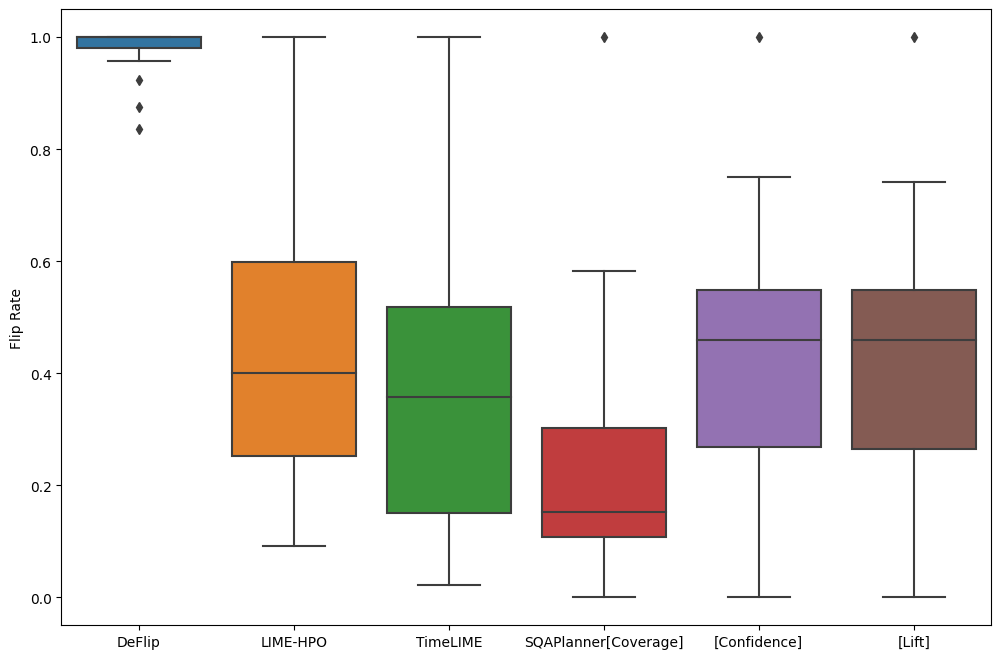

In [2]:
# Flip rate of each explainer
import pickle
from data_utils import read_dataset
from hyparams import EXPERIMENTS, MODELS, PLOTS
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

projects = read_dataset()
project_list = list(sorted(projects.keys()))

explainer_list = ['DeFlip', 'LIMEHPO', 'TimeLIME', 'coverage/SQAPlanner', 'confidence/SQAPlanner', 'lift/SQAPlanner']
statistics = {}
for project in project_list:
    _, test = projects[project]
    positives = test.loc[test['target'] == True]
    model_path = Path(MODELS) / project / 'RandomForest.pkl'
    with open(model_path, 'rb') as f:
        model = pickle.load(f)
    predictions = model.predict(positives.drop(columns=['target']).values)
    true_positives = positives.loc[predictions == True]
    
    total = len(true_positives)
    for explainer in explainer_list:
        flipped_instances_df = pd.read_csv(Path(EXPERIMENTS) / project / f'{explainer}.csv', index_col=0)
        assert set(flipped_instances_df.index.values).issubset(set(true_positives.index.values))
        flip_rate = len(flipped_instances_df) / total
        statistics[explainer] = statistics.get(explainer, []) + [flip_rate]

df = pd.DataFrame(statistics, index=project_list)
df = df.melt(var_name='Explainer', value_name='Flip Rate')
plt.figure(figsize=(12, 8))
sns.boxplot(x='Explainer', y='Flip Rate', data=df)

# hide the x axis label
plt.xlabel('')

x_labels = ['DeFlip', 'LIME-HPO', 'TimeLIME', 'SQAPlanner[Coverage]', '[Confidence]', '[Lift]']
plt.xticks(range(len(x_labels)), x_labels)

plot_path = Path(PLOTS)
plot_path.mkdir(parents=True, exist_ok=True)
plt.savefig(plot_path / 'flip_rate.png')
plt.show()

In [ ]:
#TODO: add statistical test (Scott-Knott ESD) (https://github.com/klainfo/ScottKnottESD)

### Ex2. 각 explainer의 proposed changes를 최대한으로 만족시키면서 제안된 범위 내에서 변경시켰을 때 decision flip이 얼마나 발생하는지 비율을 조사한다.

